In [1]:
import pandas as pd


df = pd.read_json(
    "agg_data/ParlaMint-SI.speeches.jsonl",
    lines=True,
    # nrows=10000
)
df = pd.concat([df, df.metadata.apply(pd.Series)], axis=1)


In [2]:

# Filtering
# Keep only MPs
c1 = (df.Speaker_MP == "MP") & (df.Speaker_minister == "notMinister")


# Keep only speeches where speaker is either Opposition or Coalition:
c2 = df.Party_status.isin(["Opposition", "Coalition"])

# Keep only people that have at least 10 speeches:
gb = df.groupby(["Speaker_name", "Party_status"]).logits_pondered.count().reset_index()
speakers_to_keep = gb[gb.logits_pondered >= 10].Speaker_name.unique()
c3 = df.Speaker_name.isin(speakers_to_keep)

ndf = df[c1&c2&c3].reset_index(drop=True).dropna(subset="logits_pondered")
ndf.head(3)

,newdoc id,logits_pondered,logits_averaged,char_length,metadata,Text_ID,ID,Title,Date,Body,...,Speaker_MP,Speaker_minister,Speaker_party,Speaker_party_name,Party_status,Party_orientation,Speaker_ID,Speaker_name,Speaker_gender,Speaker_birth
0,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u1,2.497539,3.236904,1005,{'Text_ID': 'ParlaMint-SI-en_2022-04-06-SDZ8-I...,ParlaMint-SI-en_2022-04-06-SDZ8-Izredna-99,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u1,Minutes of the National Assembly of the Republ...,2022-04-06,Lower house,...,MP,notMinister,DeSUS,Demokratična stranka upokojencev Slovenije,Coalition,Centre to centre-left,SimonovičBranko,"Simonovič, Branko",M,1953
1,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u3,3.269488,3.741684,127,{'Text_ID': 'ParlaMint-SI-en_2022-04-06-SDZ8-I...,ParlaMint-SI-en_2022-04-06-SDZ8-Izredna-99,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u3,Minutes of the National Assembly of the Republ...,2022-04-06,Lower house,...,MP,notMinister,DeSUS,Demokratična stranka upokojencev Slovenije,Coalition,Centre to centre-left,SimonovičBranko,"Simonovič, Branko",M,1953
2,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u5,3.173941,3.532954,149,{'Text_ID': 'ParlaMint-SI-en_2022-04-06-SDZ8-I...,ParlaMint-SI-en_2022-04-06-SDZ8-Izredna-99,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u5,Minutes of the National Assembly of the Republ...,2022-04-06,Lower house,...,MP,notMinister,DeSUS,Demokratična stranka upokojencev Slovenije,Coalition,Centre to centre-left,SimonovičBranko,"Simonovič, Branko",M,1953


In [3]:
ndf[ndf.Speaker_name == "Lukšič, Igor"].groupby(["Speaker_name"]).agg({
    "logits_pondered": ["mean", "count"]
}).reset_index()

Speaker_name logits_pondered      
                           mean count
0  Lukšič, Igor        4.033764     1

In [5]:
pd.set_option('display.max_rows', None)
gb1 = ndf.groupby(["Speaker_name", "Party_status"]).agg({
    "logits_pondered": ["mean", "count"]
}).reset_index()
gb1 = gb1.set_axis(gb1.columns.map(lambda l: '_'.join(l).rstrip("_").replace("logits_pondered_", "")), axis=1,)
gb2 = ndf.groupby(["Speaker_name"]).agg({
    "logits_pondered": ["mean", "count"]
}).reset_index()

gb2 = gb2.set_axis(gb2.columns.map(lambda l: '_'.join(l).rstrip("_").replace("logits_pondered_", "")), axis=1,)

gb2["Coalition_mean"] = gb2[["Speaker_name"]].merge(gb1[gb1["Party_status"]=="Coalition"], on="Speaker_name", how="left")["mean"]
gb2["Opposition_mean"] = gb2[["Speaker_name"]].merge(gb1[gb1["Party_status"]=="Opposition"], on="Speaker_name", how="left")["mean"]
gb2["Coalition_count"] = gb2[["Speaker_name"]].merge(gb1[gb1["Party_status"]=="Coalition"], on="Speaker_name", how="left")["count"]
gb2["Opposition_count"] = gb2[["Speaker_name"]].merge(gb1[gb1["Party_status"]=="Opposition"], on="Speaker_name", how="left")["count"]
gb2["Coal minus Oppo"] = gb2.Coalition_mean - gb2.Opposition_mean
gb2 = gb2.sort_values(by="count", ascending=False)
gb2

,Speaker_name,mean,count,Coalition_mean,Opposition_mean,Coalition_count,Opposition_count,Coal minus Oppo
43,"Cukjati, France",3.243524,15735,3.272720,3.177705,10900.0,4835.0,0.095014
140,"Klavora, Vasja",3.264781,13694,3.269648,3.187978,12878.0,816.0,0.081670
30,"Brglez, Milan",2.973514,11952,2.973514,NaN,11952.0,NaN,NaN
68,"Gantar, Pavel",3.026480,10607,3.061883,2.492048,9948.0,659.0,0.569835
236,"Pavlinič Krebs, Irma",3.142278,10383,3.142278,NaN,10383.0,NaN,NaN
230,"Pahor, Borut",3.020809,9392,3.021020,2.773671,9384.0,8.0,0.247349
311,"Tanko, Jože",2.654093,8901,2.935771,2.374118,4437.0,4464.0,0.561652
249,"Peče, Sašo",2.972778,7633,NaN,2.972778,NaN,7633.0,NaN
91,"Hainz, Primož",3.231165,7256,3.231165,NaN,7256.0,NaN,NaN
264,"Potrč, Miran",2.935390,7039,3.046301,2.012255,6284.0,755.0,1.034046


<Axes: xlabel='Opposition_mean', ylabel='Coal minus Oppo'>

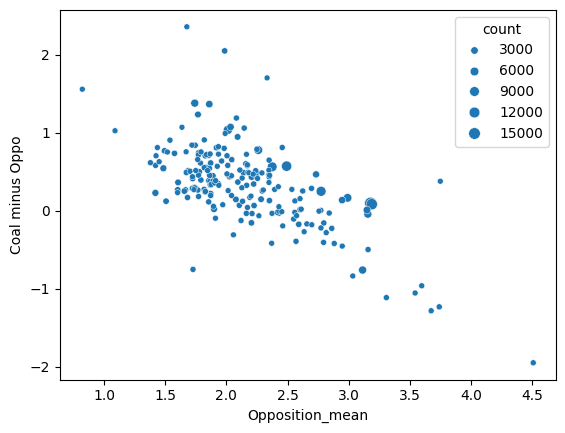

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=gb2,
    y = "Coal minus Oppo",
    x = "Opposition_mean",
    size="count"
)


<Axes: xlabel='Coalition_mean', ylabel='Opposition_mean'>

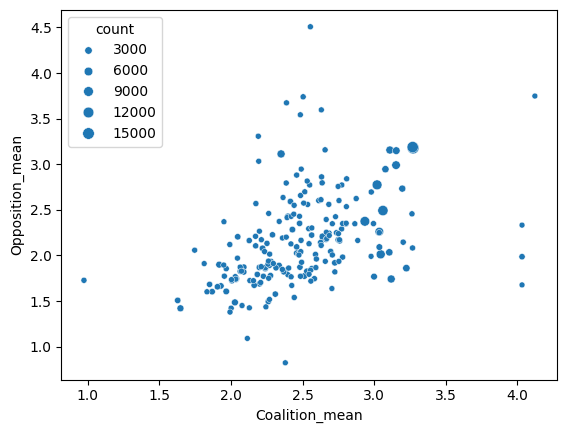

In [7]:
sns.scatterplot(
    data=gb2,
    x = "Coalition_mean",
    y = "Opposition_mean",
    size="count"
)

/home/peterr/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


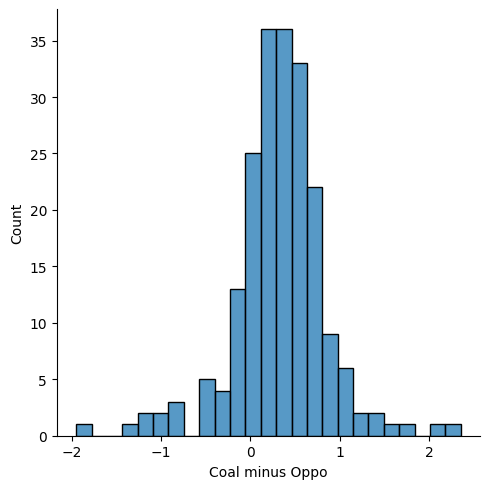

In [8]:
sns.displot(gb2, x="Coal minus Oppo")